<a href="https://colab.research.google.com/github/rlaaudrb1104/Ai/blob/LEE/codebert_final(06-20)_no_safecode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers[torch]
!pip install accelerate
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 2.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [26]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, RobertaConfig, RobertaModel, RobertaPreTrainedModel, Trainer, TrainingArguments
import torch.nn as nn
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
import re

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
# CUDA 디버깅 설정
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# CSV 파일 로드
df = pd.read_csv("/content/drive/MyDrive/last_model/last_dataset(06-19)_nosafe_version.csv")

In [28]:
df

,Unnamed: 0,code_x,lang,CWE ID,vul,code_y
0,0,void char_01()\n{\n char * data;\n /* In...,0,CWE-415,1,data = NULL;\ndata = (char *)malloc(100*sizeof...
1,1,void char_02()\n{\n char * data;\n /* In...,0,CWE-415,1,data = NULL;\ndata = (char *)malloc(100*sizeof...
2,2,void char_03()\n{\n char * data;\n /* In...,0,CWE-415,1,data = NULL;\nif(5==5)\ndata = (char *)malloc(...
3,3,void char_04()\n{\n char * data;\n /* In...,0,CWE-415,1,data = NULL;\ndata = (char *)malloc(100*sizeof...
4,4,void char_05()\n{\n char * data;\n /* In...,0,CWE-415,1,data = NULL;\ndata = (char *)malloc(100*sizeof...
...,...,...,...,...,...,...
7289,9911,"static void fix_dl_name(MEM_ROOT *root, LEX_ST...",0,CWE-416,1,const size_t so_ext_len= sizeof(SO_EXT) - 1;\n...
7290,9912,"static int post_msg(struct pptp_conn_t *conn, ...",0,CWE-787,1,"if (conn->out_size) {\nn=write(conn->hnd.fd, b..."
7291,9913,static void zlib_stateful_free_ex_data(void *o...,0,CWE-399,1,struct zlib_state *state = (struct zlib_state ...
7292,9914,COMP_METHOD *COMP_zlib(void)\n\t{\n\tCOMP_METH...,0,CWE-399,1,COMP_METHOD *meth = &zlib_method_nozlib;


In [29]:
df.rename(columns={'code_x': 'code'}, inplace=True)

In [30]:
cwe_counts = df['CWE ID'].value_counts().reset_index()
cwe_counts.columns = ['CWE ID', 'count']
cwe_counts['labels'] = range(len(cwe_counts))

In [31]:
df = df.merge(cwe_counts[['CWE ID', 'labels']], on='CWE ID', how='left')
df = df.drop(columns = ['Unnamed: 0'])

In [32]:
df

,code,lang,CWE ID,vul,code_y,labels
0,void char_01()\n{\n char * data;\n /* In...,0,CWE-415,1,data = NULL;\ndata = (char *)malloc(100*sizeof...,0
1,void char_02()\n{\n char * data;\n /* In...,0,CWE-415,1,data = NULL;\ndata = (char *)malloc(100*sizeof...,0
2,void char_03()\n{\n char * data;\n /* In...,0,CWE-415,1,data = NULL;\nif(5==5)\ndata = (char *)malloc(...,0
3,void char_04()\n{\n char * data;\n /* In...,0,CWE-415,1,data = NULL;\ndata = (char *)malloc(100*sizeof...,0
4,void char_05()\n{\n char * data;\n /* In...,0,CWE-415,1,data = NULL;\ndata = (char *)malloc(100*sizeof...,0
...,...,...,...,...,...,...
7289,"static void fix_dl_name(MEM_ROOT *root, LEX_ST...",0,CWE-416,1,const size_t so_ext_len= sizeof(SO_EXT) - 1;\n...,5
7290,"static int post_msg(struct pptp_conn_t *conn, ...",0,CWE-787,1,"if (conn->out_size) {\nn=write(conn->hnd.fd, b...",4
7291,static void zlib_stateful_free_ex_data(void *o...,0,CWE-399,1,struct zlib_state *state = (struct zlib_state ...,7
7292,COMP_METHOD *COMP_zlib(void)\n\t{\n\tCOMP_METH...,0,CWE-399,1,COMP_METHOD *meth = &zlib_method_nozlib;,7


In [33]:
df_count = df[['CWE ID','labels']].value_counts()
df_count

CWE ID   labels
CWE-415  0         1658
CWE-119  1         1236
CWE-20   2          813
CWE-125  3          808
CWE-787  4          717
CWE-416  5          588
CWE-476  6          519
CWE-399  7          503
CWE-190  8          452
Name: count, dtype: int64

In [34]:
df = df[['code', 'code_y','labels','lang']]

In [35]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
# 오버샘플링 적용
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(df.drop(columns=['labels']), df['labels'])

# 오버샘플링 후 클래스 분포 확인
print(f"Resampled dataset shape: {Counter(y_res)}")

# 오버샘플링된 데이터를 다시 Dataset 객체로 변환

df = pd.concat([X_res, y_res], axis=1)

Resampled dataset shape: Counter({0: 1658, 1: 1658, 2: 1658, 5: 1658, 7: 1658, 8: 1658, 3: 1658, 6: 1658, 4: 1658})


In [36]:
def preprocess(df, file_name):
    # 멀티 라인 주석 제거
    df['code'] = df['code'].replace(re.compile(r'/\*.*?\*/', re.DOTALL), "", regex=True)
    # 싱글 라인 주석 제거
    df['code'] = df['code'].replace(re.compile(r'//.*?\n'), "", regex=True)
    # angle brackets를 사용하는 include 제거
    df['code'] = df['code'].replace(re.compile(r'#include .*?\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#include "*.*?\n'), "", regex=True)
    # 매크로 정의 제거
    df['code'] = df['code'].replace(re.compile(r'#define .*?\n'), "", regex=True)
    # 전처리 지시문 제거
    df['code'] = df['code'].replace(re.compile(r'#undef\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#if\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#else\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#elif\s+\w+'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'#endif'), "", regex=True)
    # 탭과 여러 공백을 하나의 공백으로
    df['code'] = df['code'].replace(re.compile(r'[\t ]+'), " ", regex=True)
    # 여러 줄바꿈을 하나로
    df['code'] = df['code'].replace(re.compile(r'\n\s*\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'\n'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'return*.*?;'), "", regex=True)
    df['code'] = df['code'].replace(re.compile(r'return;'), "", regex=True)

    # 데이터프레임을 CSV 파일로 저장
    df.to_csv(file_name, index=False)
    return df  # 수정된 데이터프레임 반환

df = preprocess(df, "preprocess.csv")

df = pd.read_csv("preprocess.csv")

In [37]:
# code와 code_y 컬럼, 라벨 컬럼, 피쳐 컬럼 분리
code_texts = df['code'].tolist()
code_y_texts = df['code_y'].tolist()
labels = df['labels'].tolist()

In [38]:
# 라벨이 0부터 9까지 있는지 확인
assert all(0 <= label < 9 for label in labels), "라벨이 0부터 9까지의 범위에 있어야 합니다."

features = df.drop(columns=['code', 'code_y', 'labels']).values.astype(np.float32)  # float 타입으로 변환

# 피처 크기 확인 및 설정
feature_size = features.shape[1]
print(f"Feature size: {feature_size}")

# 토크나이저 초기화
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

Feature size: 1


In [39]:
# code와 code_y 컬럼을 토큰화
encodings = tokenizer(code_texts, padding=True, truncation=True, return_tensors='pt')
code_y_encodings = tokenizer(code_y_texts, padding=True, truncation=True, return_tensors='pt')

In [40]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import RobertaModel, RobertaConfig, RobertaPreTrainedModel

# 데이터셋 클래스 정의
class CodeDataset(Dataset):
    def __init__(self, encodings, code_y_encodings, labels, features):
        self.encodings = encodings
        self.code_y_encodings = code_y_encodings
        self.labels = labels
        self.features = features

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        code_y_item = {f'code_y_{key}': val[idx] for key, val in self.code_y_encodings.items()}
        item.update(code_y_item)
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        item['features'] = torch.tensor(self.features[idx], dtype=torch.float)
        return item


In [41]:
# 데이터셋 생성 및 분리
train_texts, val_texts, train_code_y_texts, val_code_y_texts, train_labels, val_labels, train_features, val_features = train_test_split(
    code_texts, code_y_texts, labels, features, test_size=0.2, random_state=42)

train_encodings = tokenizer(train_texts, padding=True, truncation=True, return_tensors='pt')
val_encodings = tokenizer(val_texts, padding=True, truncation=True, return_tensors='pt')

train_code_y_encodings = tokenizer(train_code_y_texts, padding=True, truncation=True, return_tensors='pt')
val_code_y_encodings = tokenizer(val_code_y_texts, padding=True, truncation=True, return_tensors='pt')

train_dataset = CodeDataset(train_encodings, train_code_y_encodings, train_labels, train_features)
val_dataset = CodeDataset(val_encodings, val_code_y_encodings, val_labels, val_features)


In [42]:
# 모델 정의
class CodeBERTConfig(RobertaConfig):
    model_type = "codebert"

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.max_position_embeddings = 514  # 사전 학습된 모델과 일치
        self.type_vocab_size = 1  # 사전 학습된 모델과 일치
        self.output_attentions = True  # 어텐션 가중치 반환 설정

class CodeBERTForVulnerabilityDetectionWithFeatures(RobertaPreTrainedModel):
    config_class = CodeBERTConfig

    def __init__(self, config, feature_size):
        super().__init__(config)
        self.num_labels = 9  # 0부터 9까지의 10개 클래스
        self.feature_size = feature_size
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.feature_dense = nn.Linear(self.feature_size, config.hidden_size)
        self.code_y_dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size * 3, self.num_labels)  # Concatenate RoBERTa output with features and code_y
        self.init_weights()

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, code_y_input_ids=None, code_y_attention_mask=None, features=None, labels=None, return_attentions=False):
        if features is None:
            raise ValueError("features를 제공해야 합니다.")

        outputs = self.roberta(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, output_attentions=return_attentions)
        sequence_output = outputs[0]
        attentions = outputs.attentions if return_attentions else None

        code_y_outputs = self.roberta(code_y_input_ids, attention_mask=code_y_attention_mask, output_attentions=return_attentions)
        code_y_sequence_output = code_y_outputs[0]
        code_y_attentions = code_y_outputs.attentions if return_attentions else None

        pooled_output = sequence_output[:, 0, :]
        pooled_output = self.dropout(pooled_output)

        code_y_pooled_output = code_y_sequence_output[:, 0, :]
        code_y_pooled_output = self.dropout(code_y_pooled_output)
        code_y_pooled_output = self.code_y_dense(code_y_pooled_output)
        code_y_pooled_output = self.dropout(code_y_pooled_output)

        feature_output = self.feature_dense(features)
        feature_output = self.dropout(feature_output)

        combined_output = torch.cat((pooled_output, code_y_pooled_output, feature_output), dim=1)
        logits = self.classifier(combined_output)

        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            if return_attentions:
                return {"loss": loss, "logits": logits, "attentions": attentions, "code_y_attentions": code_y_attentions}
            return {"loss": loss, "logits": logits}

        if return_attentions:
            return {"logits": logits, "attentions": attentions, "code_y_attentions": code_y_attentions}

        return {"logits": logits}

def model_load():
    # 모델 초기화
    config = CodeBERTConfig()
    feature_size = 769  # 예시로 feature size 설정, 실제 값에 맞게 조정 필요 (언어 정보 추가로 +1)
    model = CodeBERTForVulnerabilityDetectionWithFeatures(config, feature_size=feature_size)

    # 사전 학습된 가중치 로드
    pretrained_model = RobertaModel.from_pretrained("microsoft/codebert-base")
    model.roberta.load_state_dict(pretrained_model.state_dict(), strict=False)
    return model


In [43]:
# 커스텀 메트릭스 함수 정의
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # 각 클래스에 대한 F1 스코어 계산
    f1_per_class = f1_score(labels, predictions, average=None, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])

    # 가중 평균, 매크로 평균, 마이크로 평균 F1 스코어 계산
    f1_weighted = f1_score(labels, predictions, average='weighted')
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_micro = f1_score(labels, predictions, average='micro')
    recall_weighted = recall_score(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)

    # 결과를 딕셔너리 형태로 저장
    metrics = {
        'accuracy': accuracy,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
    }

    # 클래스별 F1 스코어를 딕셔너리에 추가
    for i, f1 in enumerate(f1_per_class):
        metrics[f'f1_class_{i}'] = f1

    return metrics

In [44]:
# 모델 초기화
config = CodeBERTConfig()
model = CodeBERTForVulnerabilityDetectionWithFeatures(config, feature_size=feature_size)



# 모델을 GPU로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

CodeBERTForVulnerabilityDetectionWithFeatures(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)


In [45]:
# TrainingArguments 설정
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=16,   # batch size for training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    evaluation_strategy="steps",     # 평가 전략을 "steps"로 설정
    eval_steps=500,                   # 500 스텝마다 평가
    fp16=True                        # 16비트 연산 사용
)

# 데이터셋을 위한 데이터 콜레이터 정의
def data_collator(features):
    input_ids = torch.stack([f['input_ids'] for f in features])
    attention_mask = torch.stack([f['attention_mask'] for f in features])
    code_y_input_ids = torch.stack([f['code_y_input_ids'] for f in features])
    code_y_attention_mask = torch.stack([f['code_y_attention_mask'] for f in features])
    labels = torch.stack([f['labels'] for f in features])
    additional_features = torch.stack([f['features'] for f in features])
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'code_y_input_ids': code_y_input_ids,
        'code_y_attention_mask': code_y_attention_mask,
        'features': additional_features,
        'labels': labels
    }

# Trainer 초기화
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    data_collator=data_collator,         # data collator for batching
    compute_metrics=compute_metrics      # 커스텀 메트릭스 함수
)

import torch
torch.cuda.empty_cache()

# 모델 훈련
trainer.train()

# 모델 평가
results = trainer.evaluate()
print(results)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,Recall Weighted,F1 Weighted,F1 Macro,F1 Micro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3,F1 Class 4,F1 Class 5,F1 Class 6,F1 Class 7,F1 Class 8
500,2.040000,1.820063,0.286097,0.286097,0.239671,0.244839,0.286097,0.941548,0.253620,0.000000,0.000000,0.070175,0.164773,0.155598,0.216092,0.401747
1000,1.455600,1.132485,0.613400,0.613400,0.597802,0.602846,0.613400,0.960754,0.345600,0.451362,0.577434,0.505643,0.693694,0.525597,0.654118,0.711409
1500,0.868200,0.747668,0.783250,0.783250,0.785112,0.787873,0.783250,0.914201,0.582500,0.760479,0.737564,0.771879,0.834483,0.776935,0.873700,0.839117
2000,0.471800,0.612771,0.828811,0.828811,0.829259,0.831257,0.828811,0.919540,0.651090,0.829268,0.771053,0.833846,0.886435,0.852989,0.897260,0.839827
2500,0.317600,0.561449,0.853601,0.853601,0.855526,0.857656,0.853601,0.963780,0.714906,0.803674,0.863095,0.849612,0.856313,0.837607,0.925325,0.904594
3000,0.231200,0.485426,0.897822,0.897822,0.896250,0.897863,0.897822,0.967136,0.755337,0.894668,0.870748,0.889236,0.911043,0.897661,0.952978,0.941957
3500,0.134400,0.504952,0.911223,0.911223,0.911293,0.912926,0.911223,0.955590,0.781609,0.897742,0.903904,0.897833,0.961905,0.926254,0.939908,0.951586
4000,0.114400,0.516019,0.921608,0.921608,0.921517,0.922705,0.921608,0.965625,0.794118,0.928668,0.910979,0.890190,0.960754,0.956522,0.957614,0.939873
4500,0.089300,0.521006,0.926298,0.926298,0.926111,0.927594,0.926298,0.970543,0.803571,0.924528,0.907246,0.896350,0.966400,0.948485,0.966825,0.964401
5000,0.042600,0.629686,0.922948,0.922948,0.922052,0.923021,0.922948,0.964230,0.802508,0.943759,0.909871,0.894049,0.945904,0.929955,0.965300,0.951613


{'eval_loss': 0.5981452465057373, 'eval_accuracy': 0.9336683417085427, 'eval_recall_weighted': 0.9336683417085427, 'eval_f1_weighted': 0.933111965646125, 'eval_f1_macro': 0.9344056028411537, 'eval_f1_micro': 0.9336683417085427, 'eval_f1_class_0': 0.9520958083832335, 'eval_f1_class_1': 0.8308157099697886, 'eval_f1_class_2': 0.929427430093209, 'eval_f1_class_3': 0.9208211143695014, 'eval_f1_class_4': 0.9159159159159159, 'eval_f1_class_5': 0.9713375796178344, 'eval_f1_class_6': 0.9533834586466166, 'eval_f1_class_7': 0.9698890649762283, 'eval_f1_class_8': 0.965964343598055, 'eval_runtime': 14.5491, 'eval_samples_per_second': 205.167, 'eval_steps_per_second': 6.461, 'epoch': 10.0}


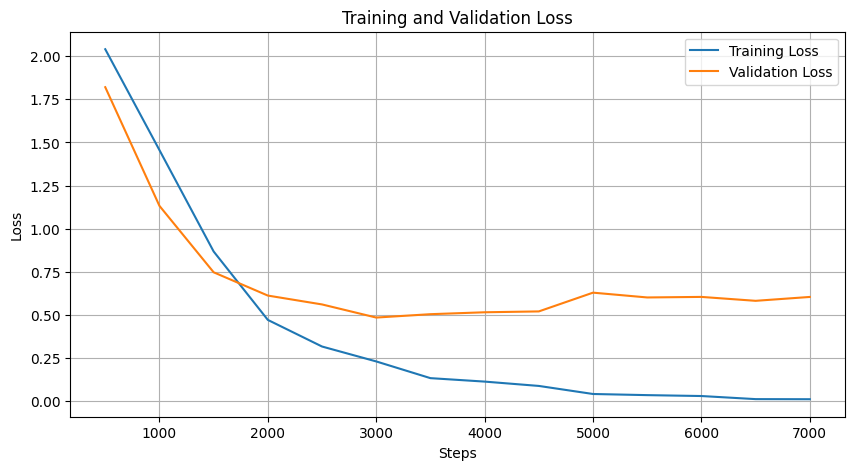

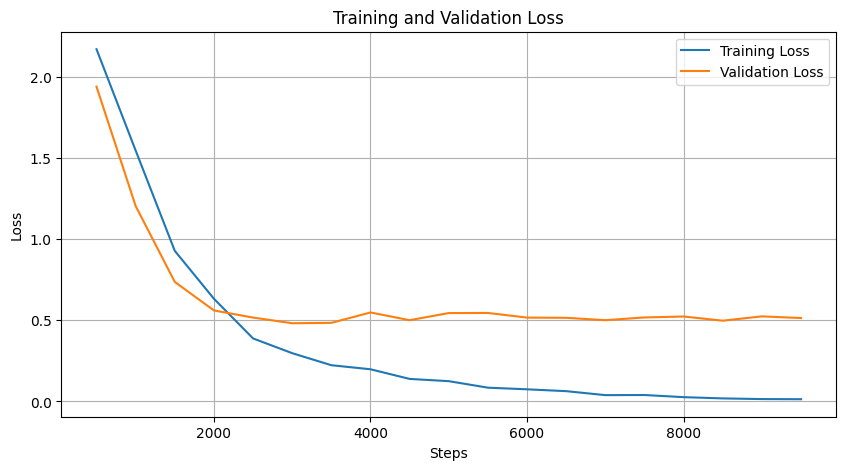

In [46]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

def plot_training_loss(log_dir):
    event_files = [os.path.join(log_dir, f) for f in os.listdir(log_dir) if 'events' in f]
    if not event_files:
        raise ValueError("No event files found in log directory.")

    for event_file in event_files:
        losses = {'Step': [], 'Training Loss': [], 'Validation Loss': []}
        for e in tf.compat.v1.train.summary_iterator(event_file):
            for v in e.summary.value:
                if v.tag == 'train/loss':
                    losses['Training Loss'].append(v.simple_value)
                    losses['Step'].append(e.step)
                elif v.tag == 'eval/loss':
                    losses['Validation Loss'].append(v.simple_value)

        if losses['Step']:
            df = pd.DataFrame(losses).set_index('Step')
            plt.figure(figsize=(10, 5))
            plt.plot(df['Training Loss'], label='Training Loss')
            plt.plot(df['Validation Loss'], label='Validation Loss')
            plt.xlabel('Steps')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.grid(True)
            plt.show()

# 로그 디렉토리를 지정하여 그래프 그리기
plot_training_loss('./logs')

In [47]:
trainer.save_model('/content/drive/MyDrive/last_model/model_codebert(slice_nosafe_feature)06-20')